In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
pd.set_option("display.max_columns", 10)

In [3]:
data = pd.read_csv('../data/clean_data/data_v1.csv', index_col=0)
data = data[data['poverty_ratio'] != 'NOT IN POVERTY UNIVERSE']
data.head()

,age,job_industry_recode,school_enroll_lastweek,employment,fam_size,...,fam_otc_med_costs,fam_rent_val,fips,state,state.1
1,67,"Not in universe, or children",Not in univ. or children & Armed Forces,0,0,...,0,0,ME,4,23
2,74,"Not in universe, or children",Not in univ. or children & Armed Forces,0,0,...,60,0,ME,4,23
3,66,"Not in universe, or children",Not in univ. or children & Armed Forces,0,1,...,0,0,ME,3,23
4,68,"Not in universe, or children",Not in univ. or children & Armed Forces,0,1,...,0,0,ME,3,23
5,52,"Not in universe, or children",No,0,1,...,0,0,ME,3,23


In [4]:
pd.set_option('display.max_columns', 10)

In [5]:
data['job_industry_recode'].value_counts()

job_industry_recode
Not in universe, or children                                  74206
Management occupations                                         9194
Office and administrative support occupations                  7044
Sales and related occupations                                  6251
Transportation and material moving occupations                 5319
Education, training, and library occupations                   4530
Healthcare practitioner and technical occupations              4469
Construction and extraction occupations                        3990
Business and financial operations occupations                  3914
Production occupations                                         3845
Food preparation and serving related occupations               3831
Computer and mathematical science occupations                  2685
Building and grounds cleaning and maintenance occupations      2647
Healthcare support occupations                                 2310
Installation, maintenance, a

In [6]:
## filter for necessary columns as determined by NB
cols = ['federal_gross_income_adj', 
        'fam_size', 
        'age', 
        'fam_med_costs', 
        'weeks_unemployed', 
        'hours_worked',
        #have to encode below all are non ordinal so will be one hot encoding
        'job_industry_recode', 
        'age_recode_gt15', 
        'highest_education', 
        'marital_status', 
        'ft_pt_unem', 
        'labor_force_recode', 
        'sex',
        'full_part_school']
education_map = {"Children":"Less than highschool",
                "11th Grade" : "Less than highschool",
                "10th Grade": "Less than highschool",
                "9th Grade" : "Less than highschool",
                "7th and 8th grade" : "Less than highschool",
                "12th Grade No Diploma" : "Less than highschool",
                "5th Or 6th Grade" : "Less than highschool",
                "1st,2nd,3rd,or 4th grade": "Less than highschool",
                "Less Than 1st Grade": "Less than highschool",
                "Bachelor's degree (BA,AB,BS)" : "Undergrad",
                "Master's degree (MA,MS,MENG,MED,MSW,MBA)": "Masters or Higher",
                "Doctorate degree (PHD,EDD)" : "Masters or Higher",
                "Professional school degree (MD,DDS,DVM,L" : "Masters or Higher",
                "Some College But No Degree" : "Some College",
                "Assc degree-academic program" : "Some College",
                "Assc degree-occupation/vocation" : "Some College"
}
age_map = {
        '75 years and over' : '65+',
        '35 to 39 years': '30-39',
        '40 to 44 years': '40-49',      
        '30 to 34 years': '30-39',        
        '45 to 49 years': '40-49',
        '50 to 54 years': '50-59',
        '55 to 59 years': '50-59',        
        '25 to 29 years': '20-29',        
        '65 to 69 years': '65+',        
        '70 to 74 years': '65+',        
        '62 to 64 years': '60-65',       
        '22 to 24 years': '20-29',        
        '16 and 17 years': '15-19',       
        '18 and 19 years': '15-19',
        '60 to 61 years': '60-65',        
        '20 and 21 years': '20-29',       
        '15 years': '15-19' 
}
job_map = {
'Not in universe, or children':'NIU',                                  
'Management occupations': 'white collar',                                         
'Office and administrative support occupations':'white collar',                  
'Sales and related occupations':'white collar',                                  
'Transportation and material moving occupations':'blue collar',                 
'Education, training, and library occupations':'gov' ,                  
'Healthcare practitioner and technical occupations': 'med',              
'Construction and extraction occupations':'blue collar',                        
'Business and financial operations occupations':'white collar',                  
'Production occupations':'blue collar',                                         
'Food preparation and serving related occupations':'service industry',               
'Computer and mathematical science occupations':'white collar',                  
'Building and grounds cleaning and maintenance occupations':'blue collar',      
'Healthcare support occupations':'med'  ,                               
'Installation, maintenance, and repair occupations': 'blue collar',              
'Personal care and service occupations':'service',                        
'Architecture and engineering occupations':'white collar',                       
'Arts, design, entertainment, sports, and media occupations':'media',     
'Protective service occupations':'blue collar',                                 
'Community and social service occupations':'med',                       
'Life, physical, and social service occupations':'med',                  
'Legal occupations':'white collar',                                               
'Farming, fishing, and forestry occupations': 'blue collar',                      
'Armed Forces':'gov'  
}
data.highest_education = data.highest_education.map(education_map)
data.age_recode_gt15 = data.age_recode_gt15.map(age_map)
data.job_industry_recode = data.job_industry_recode.map(job_map)
data = data.query('full_time_work < 2')
tree_data = data.loc[:,cols]
tree_data_encoded = pd.get_dummies(tree_data, columns=['job_industry_recode', 
        'age_recode_gt15', 
        'highest_education', 
        'marital_status', 
        'ft_pt_unem', 
        'labor_force_recode', 
        'sex'],
        drop_first=False,
        dtype=int)
for col in tree_data_encoded.columns:
    tree_data_encoded[col] = tree_data_encoded[col].astype('int64')
tree_data_encoded.head()


,federal_gross_income_adj,fam_size,age,fam_med_costs,weeks_unemployed,...,"labor_force_recode_Unemp,on layoff","labor_force_recode_W/job,not at work",labor_force_recode_Working,sex_Female,sex_Male
1,0,0,67,0,0,...,0,0,0,1,0
2,9,0,74,0,0,...,0,0,0,0,1
3,0,1,66,0,0,...,0,0,0,1,0
4,2400,1,68,0,0,...,0,0,0,1,0
5,47828,1,52,50,0,...,0,0,0,1,0


In [7]:
rus = RandomUnderSampler()
x = tree_data_encoded
y = data['poverty_ratio']
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=1111,
    test_size = 0.2
)
X_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

In [8]:
X_train_rus

,federal_gross_income_adj,fam_size,age,fam_med_costs,weeks_unemployed,...,"labor_force_recode_Unemp,on layoff","labor_force_recode_W/job,not at work",labor_force_recode_Working,sex_Female,sex_Male
103888,0,1,5,0,0,...,0,0,0,1,0
89741,0,1,14,0,0,...,0,0,0,1,0
71415,0,3,2,500,0,...,0,0,0,1,0
114301,0,0,69,60,0,...,0,0,0,0,1
93094,0,1,4,0,0,...,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
91830,0,0,29,0,0,...,0,0,0,1,0
132499,2801,1,52,400,0,...,0,0,0,1,0
18297,0,0,59,350,0,...,0,0,0,0,1
142277,0,1,0,0,0,...,0,0,0,1,0


In [9]:
y_train_rus.value_counts()

poverty_ratio
100 - 124 PERCENT OF THE POVERTY LEVEL    4460
125 - 149 PERCENT OF THE POVERTY LEVEL    4460
150 AND ABOVE THE POVERTY LEVEL           4460
BELOW POVERTY LEVEL                       4460
Name: count, dtype: int64

In [10]:
x_test

,federal_gross_income_adj,fam_size,age,fam_med_costs,weeks_unemployed,...,"labor_force_recode_Unemp,on layoff","labor_force_recode_W/job,not at work",labor_force_recode_Working,sex_Female,sex_Male
60456,0,1,11,150,0,...,0,0,0,0,1
61253,312940,1,38,3500,0,...,0,0,1,1,0
40491,115103,1,34,805,0,...,0,0,1,0,1
113407,44020,0,32,0,0,...,0,0,1,0,1
79087,0,1,1,1000,0,...,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15647,50002,2,23,300,0,...,0,0,1,1,0
59576,0,1,45,1270,0,...,0,0,1,1,0
14999,0,1,0,330,0,...,0,0,0,1,0
98278,22000,1,35,0,0,...,0,0,1,1,0


In [21]:
y_test.value_counts()

poverty_ratio
150 AND ABOVE THE POVERTY LEVEL           23509
BELOW POVERTY LEVEL                        3346
125 - 149 PERCENT OF THE POVERTY LEVEL     1217
100 - 124 PERCENT OF THE POVERTY LEVEL     1100
Name: count, dtype: int64

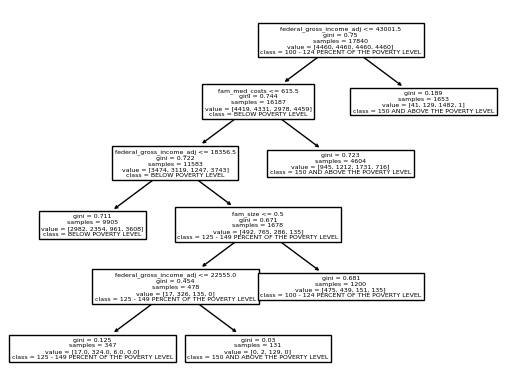

In [12]:

decision_tree=DecisionTreeClassifier(criterion='gini',
                            splitter='best', 
                            max_depth=20, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=1111, 
                            min_impurity_decrease=0.004, 
)
decision_tree.fit(X_train_rus, y_train_rus)
tree.plot_tree(decision_tree,
               feature_names = X_train_rus.columns,
               class_names = y_train_rus.unique())
plt.savefig('../site_pages/plots/Decision_Tree1.pdf')

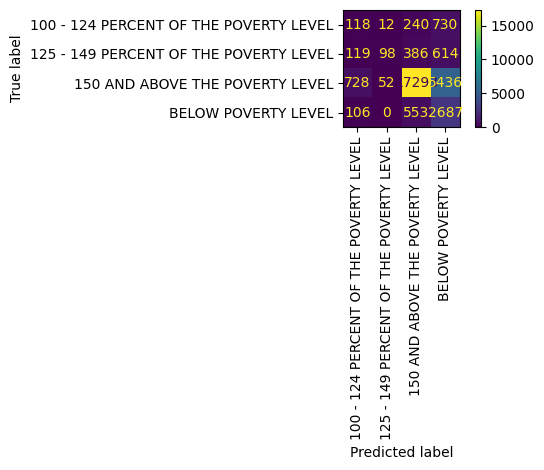

In [13]:
Decision_tree1 = decision_tree.predict(x_test)
ConfusionMatrixDisplay.from_estimator(decision_tree, x_test, y_test, xticks_rotation='vertical')
plt.tight_layout()
plt.savefig('../site_pages/plots/Decision_TreeCM.png')
Decision_tree1_accuracy = decision_tree.score(x_test, y_test)

In [14]:
Decision_tree1_accuracy

0.6923076923076923

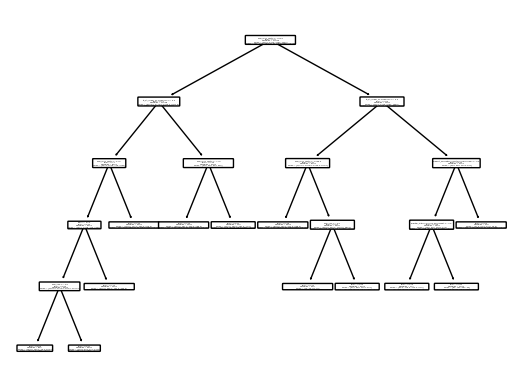

In [15]:
X_train_rus2 = X_train_rus.drop(columns = 'federal_gross_income_adj')
decision_tree2=DecisionTreeClassifier(criterion='gini',
                            splitter='best', 
                            max_depth=15, 
                            min_samples_split=2, 
                            min_samples_leaf=2, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=1111, 
                            min_impurity_decrease=0.0012, 
)
decision_tree2.fit(X_train_rus2, y_train_rus)
tree.plot_tree(decision_tree2,
               feature_names = X_train_rus2.columns,
               class_names = y_train_rus.unique(),
               rounded=True)
plt.savefig('../site_pages/plots/Decision_Tree2.pdf')

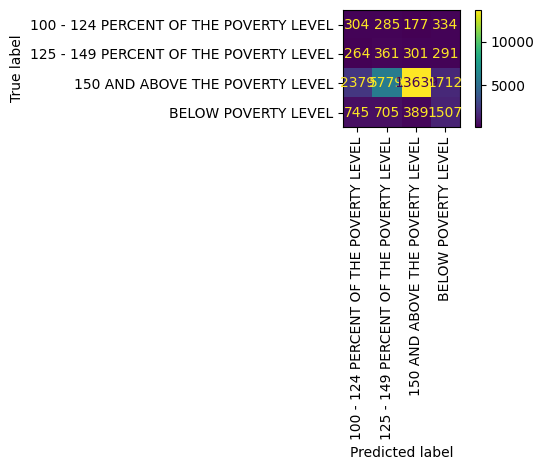

In [16]:
x_test = x_test.drop(columns = "federal_gross_income_adj")
Decision_tree2 = decision_tree2.predict(x_test)
ConfusionMatrixDisplay.from_estimator(decision_tree2, x_test, y_test, xticks_rotation='vertical')
plt.tight_layout()
plt.savefig('../site_pages/plots/Decision_Tree2CM.png')
Decision_tree2_accuracy = decision_tree2.score(x_test, y_test)

In [17]:
Decision_tree2_accuracy

0.5419923214040862

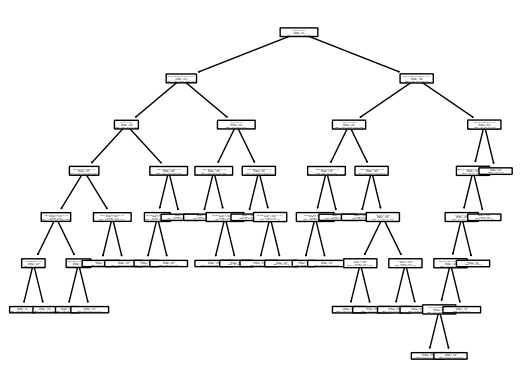

In [18]:
X_train_rus3 = X_train_rus2.drop(columns = ['age', 'marital_status_Separated'])
decision_tree3=DecisionTreeClassifier(criterion='entropy',
                            splitter='best', 
                            max_depth=10, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=1111, 
                            min_impurity_decrease=0.0012, 
)
decision_tree3.fit(X_train_rus3, y_train_rus)
tree.plot_tree(decision_tree3,
               feature_names = X_train_rus.columns,
               class_names = y_train_rus.unique(),
               rounded=True)
plt.savefig('../site_pages/plots/Decision_Tree3.pdf')

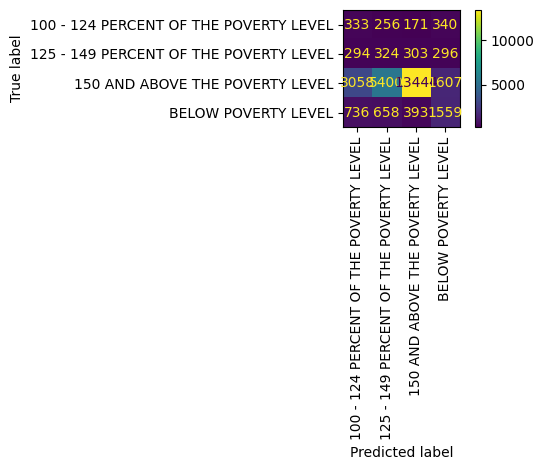

In [19]:
x_test = x_test.drop(columns = ['age', 'marital_status_Separated'])
Decision_tree3 = decision_tree3.predict(x_test)
ConfusionMatrixDisplay.from_estimator(decision_tree3, x_test, y_test, xticks_rotation='vertical')
plt.tight_layout()
plt.savefig('../site_pages/plots/Decision_Tree3CM.png')
Decision_tree3_accuracy = decision_tree3.score(x_test, y_test)

In [20]:
Decision_tree3_accuracy

0.5368161250514192